# ** What makes Youtube Videos go Viral? **

Author: Krystal Dixon (ksvrd)

There is no magic formula for making Youtube videos go viral. However, there are some features that viral Youtube Videos have in common. This kernel is an analysis of the daily record of top 200 trending videos on Youtube between November 14, 2017 & March 5, 2018. I will conduct an EDA to extract features that affect how popular a YouTube video will be.

**Over the course of this kernel we will answer the following questions:**

#### Category
- What is the most common content category that videos goes viral?

#### Engagement
- Users are more likely to engage(like, dislike, comment) in which category?
- Do dislikes affect whether a video will be viral?
- What types of videos will be disliked?
    - what tags are most common in disliked videos?
    - what tags are most common in liked videos?
- How much do subscriber count matter?
    
#### Titles and Descriptions
- What is the most common bigram in the title?
- How important is the description?
- What is the most common title length(# of words)?
- How long is the video title?
- Is title a question?

#### Tags
- How many tags do viral videos have?
- What is the most common tag?
- Do videos with controversial tags go viral?
    - what tags are most common in disliked videos?
    - what tags are most common in liked videos?

#### Time
- What is the best time of the day to post?
- How long does a video take to become viral?
- How long is the viral video?


In [1]:
set.seed(123)
library(tidyr)
library(dplyr) #for data manipulation
library(readr)
library(stringr)
library(ggplot2)
library(tidytext)
library(data.table)
library(wordcloud) #for visualizing word clouds
library(qdap) #for word frequencies
library(tm)
library(qdap)
library(rjson) #reading in json files

viral <- read_csv('../input/youtube-trend-with-subscriber/USvideos_modified.csv') #loading in the dataset with read_csv from dplyr package


Attaching package: ‚Äòdplyr‚Äô

The following objects are masked from ‚Äòpackage:stats‚Äô:

    filter, lag

The following objects are masked from ‚Äòpackage:base‚Äô:

    intersect, setdiff, setequal, union


Attaching package: ‚Äòdata.table‚Äô

The following objects are masked from ‚Äòpackage:dplyr‚Äô:

    between, first, last

Loading required package: RColorBrewer
Loading required package: qdapDictionaries
Loading required package: qdapRegex

Attaching package: ‚ÄòqdapRegex‚Äô

The following object is masked from ‚Äòpackage:ggplot2‚Äô:

    %+%

The following object is masked from ‚Äòpackage:dplyr‚Äô:

    explain

Loading required package: qdapTools

Attaching package: ‚ÄòqdapTools‚Äô

The following object is masked from ‚Äòpackage:data.table‚Äô:

    shift

The following object is masked from ‚Äòpackage:dplyr‚Äô:

    id


Attaching package: ‚Äòqdap‚Äô

The following object is masked from ‚Äòpackage:stringr‚Äô:

    %>%

The following object is masked from ‚Äòpackage:dplyr‚Äô:


## Let's Get Started!
Let's start by trying to understand our dataset. This includes looking for:
- features of the data set
- summary values of the features
- NAs and missing values

In [2]:
names(viral) #names of features of the dataset
summary(viral) # checks summary statistics, class, and NAs for each feature

[1] "video_id"                    "last_trending_date"         
 [3] "publish_date"                "publish_hour"               
 [5] "category_id"                 "channel_title"              
 [7] "views"                       "likes"                      
 [9] "dislikes"                    "comment_count"              
[11] "comments_disabled"           "ratings_disabled"           
[13] "tag_appeared_in_title_count" "tag_appeared_in_title"      
[15] "title"                       "tags"                       
[17] "description"                 "trend_day_count"            
[19] "trend.publish.diff"          "trend_tag_highest"          
[21] "trend_tag_total"             "tags_count"                 
[23] "subscriber"

   video_id         last_trending_date    publish_date         publish_hour 
 Length:4547        Min.   :2017-11-14   Min.   :2006-07-23   Min.   : 0.0  
 Class :character   1st Qu.:2017-12-10   1st Qu.:2017-12-02   1st Qu.: 8.0  
 Mode  :character   Median :2018-01-09   Median :2018-01-02   Median :15.0  
                    Mean   :2018-01-07   Mean   :2017-12-04   Mean   :13.5  
                    3rd Qu.:2018-02-04   3rd Qu.:2018-01-30   3rd Qu.:18.0  
                    Max.   :2018-03-05   Max.   :2018-03-04   Max.   :23.0  
                                                                            
  category_id    channel_title          views               likes        
 Min.   : 1.00   Length:4547        Min.   :      559   Min.   :      0  
 1st Qu.:17.00   Class :character   1st Qu.:    90896   1st Qu.:   1486  
 Median :24.00   Mode  :character   Median :   318840   Median :   7397  
 Mean   :20.42                      Mean   :  1265665   Mean   :  39197  
 3rd Qu.:25.00

### Key Take Aways

* There are trending videos with only 559 views and there are ones with over 149 million views.
* There are trending videos with no likes and there are ones up to over 3 million.
* There are trending videos with over 1.6 million dislikes as well as ones with none.
* There are trending videos with no comments and those with over one million.
* There are trending videos that was published 4,215 days (approx. 11 months) before going viral, and those that went viral the day it was published.
* There are trending videos with no tags and those with up to 69 tags.
* There are trending videos with **no subscribers** and those with up to 28 million.

***I've mainly looked at the max and the mins of key features. I will go further into frequencies and averages further into this kernel.
*

## Categories

#### Key Question
- What is the most common content category that goes viral?

In [3]:
#Matching Category names to Category IDs from US_category_id.json file

cat_names <- fromJSON(file = "../input/youtube-new/US_category_id.json")

#extracting ids of categories into a vector
list <- cat_names[["items"]]
items <- length(list)

ids <- numeric(items)
for(i in seq_along(list)){
  ids[i] <- cat_names[["items"]][[i]][[3]]
}

#extracting names of categories into a vector
names <- character(items)
for(i in seq_along(list)){
  names[i] <- cat_names[["items"]][[i]][[4]][[2]]
}

#addressing the duplicate label, Comedy, by changing the duplicated value to Comedy2
names <- c('Film & Animation', 'Autos & Vehicles', 'Music', 'Pets & Animals', 'Sports', 
           'Short Movies', 'Travel & Events', 'Gaming', 'Videoblogging', 'People & Blogs', 
           'Comedy', 'Entertainment', 'News & Politics', 'Howto & Style', 'Education', 
           'Science & Technology', 'Nonprofits & Activism', 'Movies', 'Anime/Animation', 
           'Action/Adventure', 'Classics', 'Comedy2', 'Documentary', 'Drama', 'Family', 
           'Foreign', 'Horror', 'Sci-Fi/Fantasy', 'Thriller', 'Shorts', 'Shows', 'Trailers')

#creating new column, category
viral$categories <- factor(viral$category_id, levels = ids, labels = names)

Warning message:
‚ÄúIgnoring unknown parameters: binwidth, bins, pad‚Äù

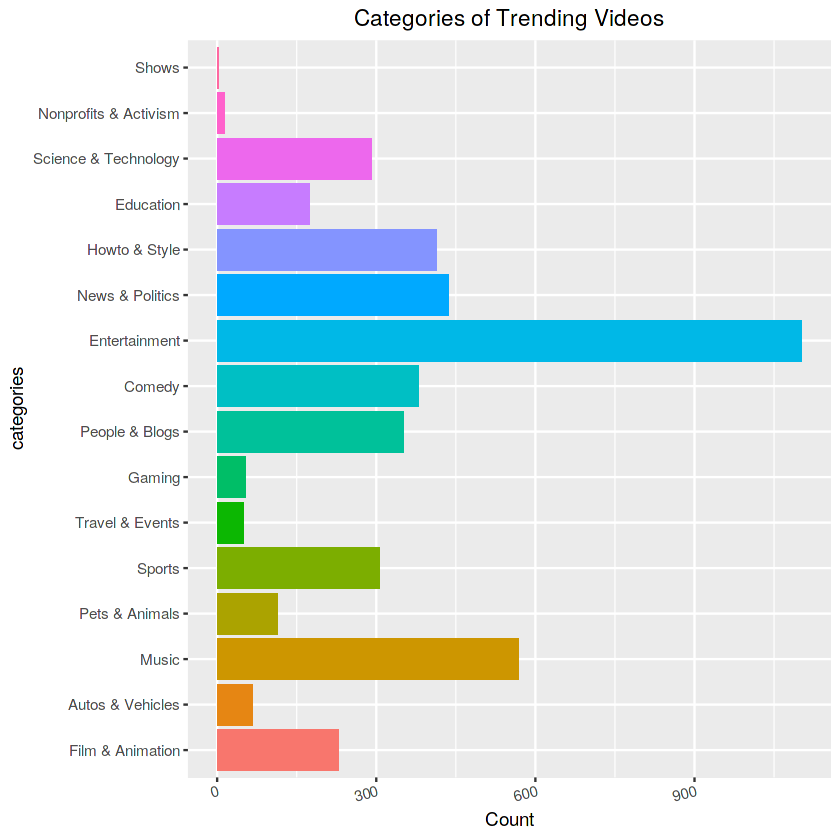

In [4]:
# Top Categories
top_cat_bp <- ggplot(viral, aes(categories, fill = categories)) +
                  geom_histogram(stat = "count") +
                  labs(y = 'Count', title = 'Categories of Trending Videos') +
                  theme(plot.title = element_text(hjust = 0.5), 
                        axis.text.x = element_text(angle = 15, hjust = 1), 
                        legend.position="none")+
                  coord_flip()

top_cat_bp

The Top 5 Trending Categories are:
* Entertainment - almost twice the number of Music viral videos
* Music
* News & Politics
* HowTo & Style
* Comedy

## Engagement

#### Key Questions

- Users are more likely to engage(like, dislike, comment) in which category?
- Do dislikes negatively affect likelihood of being viral?
- Common Tags based on engagement?
    - what tags are most common in disliked videos?
    - what tags are most common in liked videos?
- How much do subscriber count matter?

**Highest to Lowest Engagement** (sum of likes, dislikes, and comments) by Category.
    n represents number of trending videos in that category

In [5]:
#Categories with the highest engagement(sum of likes, dislikes, and comments) arranged from highest to lowest
engagement <- viral %>% group_by(categories) %>% 
                        mutate(engagement = sum(likes, dislikes, comment_count)) %>% 
                        count(engagement) %>% 
                        arrange(desc(engagement))
engagement

categories            engagement n   
1  Music                 76829360    568
2  Entertainment         48405862   1102
3  Comedy                20844154    380
4  People & Blogs        13170588    352
5  Howto & Style         12814663    413
6  Film & Animation      10097504    228
7  Science & Technology   7418936    291
8  Sports                 7234706    306
9  Nonprofits & Activism  3680626     13
10 Education              3364822    175
11 News & Politics        3195831    436
12 Pets & Animals         2175823    113
13 Gaming                 2086417     53
14 Autos & Vehicles        777312     66
15 Travel & Events         478660     49
16 Shows                     8515      2

Percentage of Engagement of Likes & Dislikes Over Time
- Blue: Likes
- Green: Dislikes
- Red: Comments

Warning message:
‚ÄúRemoved 45 rows containing missing values (geom_point).‚Äù

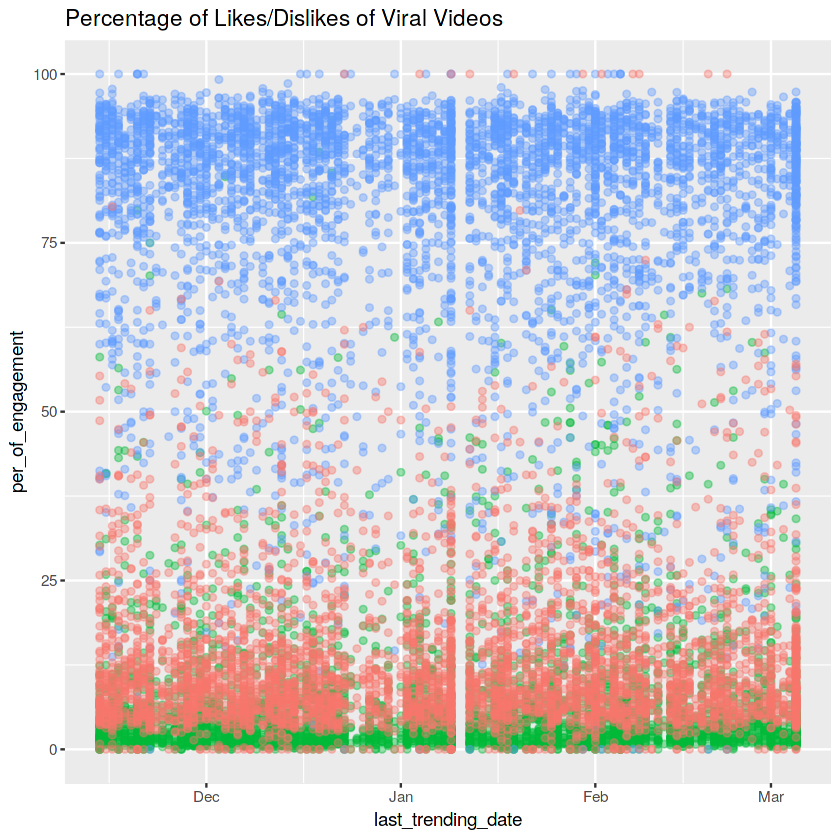

In [6]:
dis_likes_per <- viral %>% mutate(engagement = (likes+dislikes+comment_count), 
                                 'dislikes_engagement' = ((dislikes/engagement)*100),
                                 'likes_engagement' = ((likes/engagement)*100),
                                 'comment_engagement' = ((comment_count/engagement)*100)) %>%
                           select(last_trending_date, dislikes_engagement, likes_engagement, comment_engagement) %>%
                           arrange(desc(dislikes_engagement))
plot <- dis_likes_per %>% gather(dis_likes, per_of_engagement, dislikes_engagement, likes_engagement, comment_engagement)

ggplot(plot, aes(last_trending_date, per_of_engagement, color = dis_likes)) + 
    geom_point(alpha = .4) +
    ggtitle("Percentage of Likes/Dislikes of Viral Videos") +
    theme(legend.position="none")

Most Common Tags of Videos where **dislikes** makeup over One Third of their Engagement

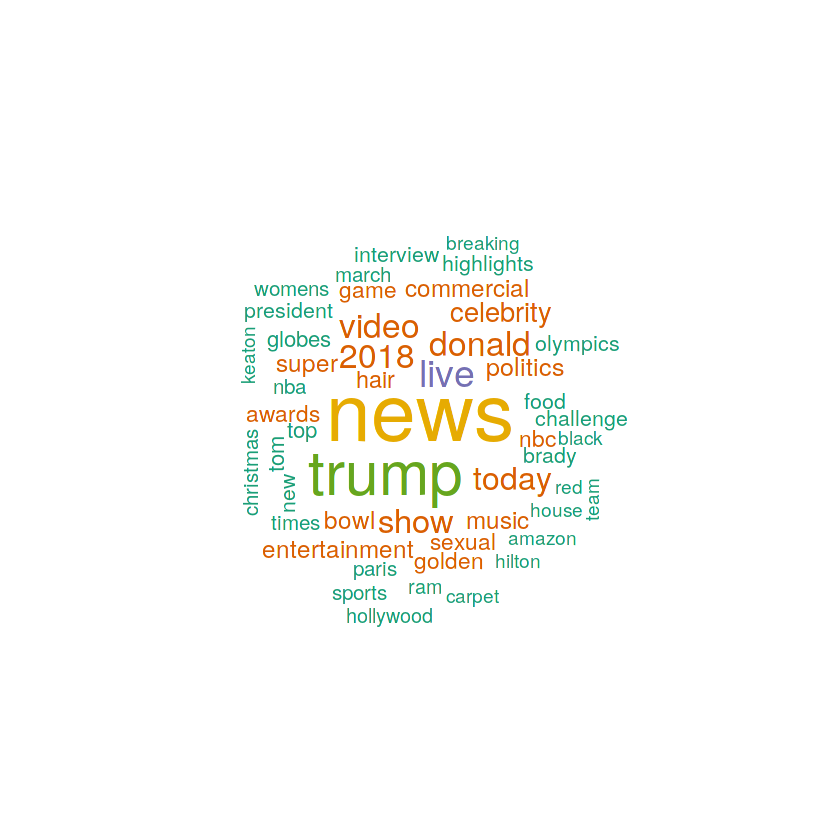

In [7]:
viral2 <- viral %>% mutate(engagement = (likes+dislikes+comment_count), 
                               'dislikes_engagement' = ((dislikes/engagement)*100),
                               'likes_engagement' = ((likes/engagement)*100)) %>%
                    filter(dislikes_engagement > 33)

tags <- as.character(viral2$tags) #create a vector of tags
tags <- strsplit(tags, "\\|")

tags_source <- VectorSource(tags)
tags_corpus <- VCorpus(tags_source)

clean_corpus <- function(corpus) {
  # Remove punctuation
  corpus <- tm_map(corpus, removePunctuation)
  # Transform to lower case
  corpus <- tm_map(corpus, content_transformer(tolower))
  # Add more stopwords
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  # Strip whitespace
  corpus <- tm_map(corpus, stripWhitespace)
  return(corpus)
}

tags_clean <- clean_corpus(tags_corpus)
tags_tdm <- TermDocumentMatrix(tags_clean)# Create a TDM from desc_clean
tags_m <- as.matrix(tags_tdm) # Convert desc_tdm to a matrix

# Calculate the rowSums: term_frequency
term_frequency <- rowSums(tags_m)

# Sort term_frequency in descending order
term_frequency <- sort(term_frequency, decreasing = TRUE)

words <- names(term_frequency)

# Word Cloud
wordcloud(words, term_frequency, max.words = 50, colors = brewer.pal(6,"Dark2"), random.order = F)

Most Common Tags of Videos where **likes** makeup over One Third of their Engagement

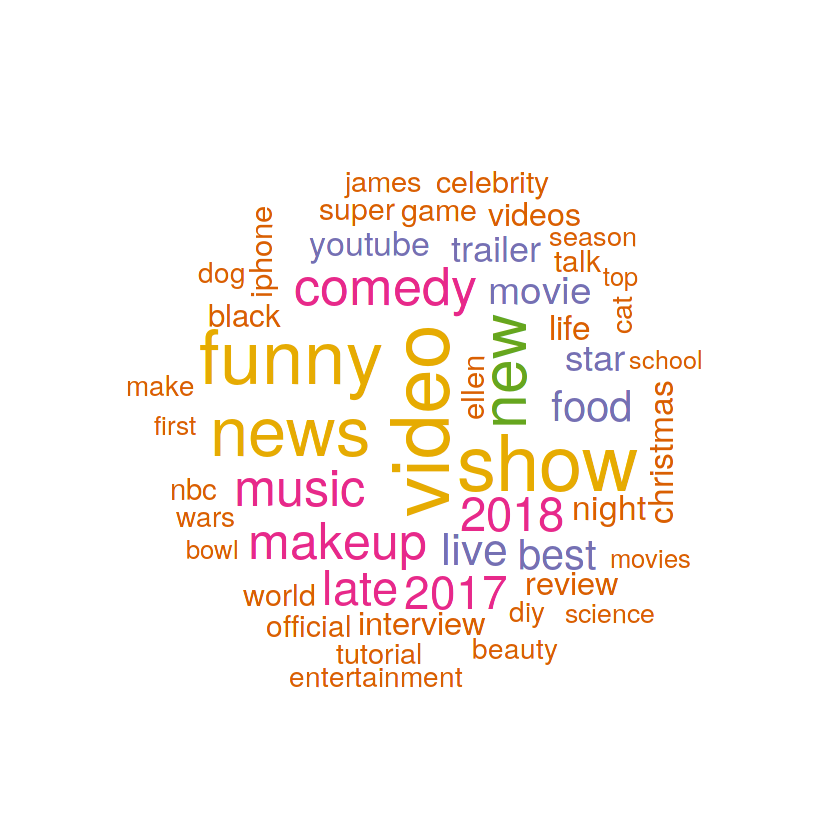

In [8]:
viral3 <- viral %>% mutate(engagement = (likes+dislikes+comment_count), 
                           'dislikes_engagement' = ((dislikes/engagement)*100),
                           'likes_engagement' = ((likes/engagement)*100)) %>%
                    filter(likes_engagement > 33)

tags3 <- as.character(viral3$tags) #create a vector of tags
tags3 <- strsplit(tags3, "\\|")

tags3_source <- VectorSource(tags3)
tags3_corpus <- VCorpus(tags3_source)

tags3_clean <- clean_corpus(tags3_corpus)
tags3_tdm <- TermDocumentMatrix(tags3_clean)# Create a TDM from desc_clean
tags3_m <- as.matrix(tags3_tdm) # Convert desc_tdm to a matrix

# Calculate the rowSums: term_frequency
term_frequency2 <- rowSums(tags3_m)

# Sort term_frequency in descending order
term_frequency2 <- sort(term_frequency2, decreasing = TRUE)

words2 <- names(term_frequency2)

# Word Cloud
wordcloud(words2, term_frequency2, max.words = 50, colors = brewer.pal(6,"Dark2"), random.order = F)

Warning message:
‚ÄúRemoved 22 rows containing non-finite values (stat_smooth).‚ÄùWarning message:
‚ÄúRemoved 22 rows containing missing values (geom_point).‚Äù

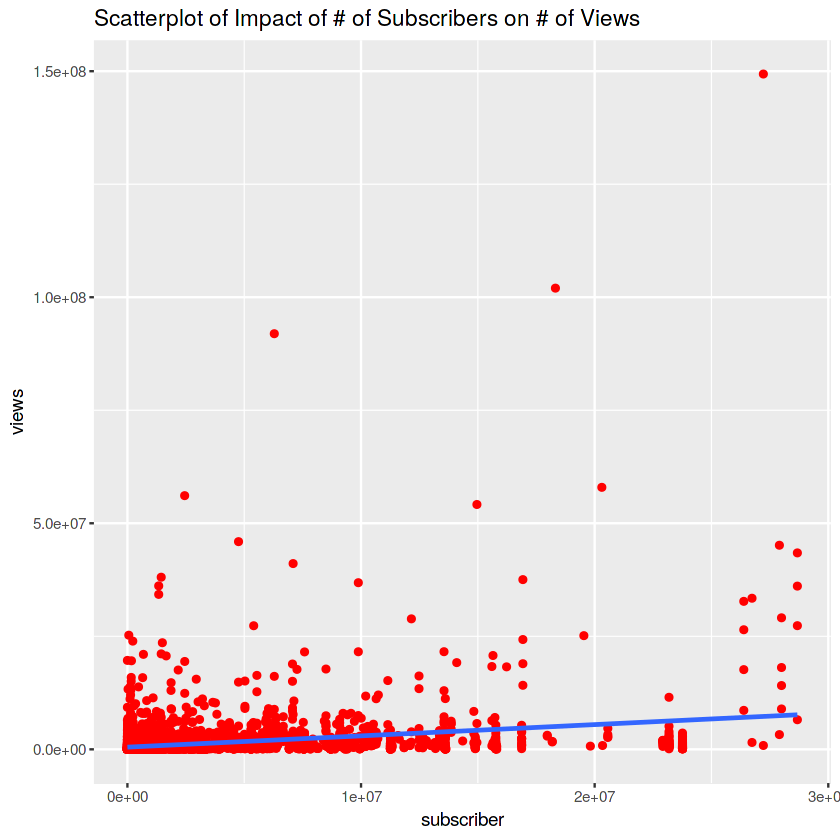

In [9]:
ggplot(viral, aes(subscriber, views)) + 
    geom_point(color='red') +
    geom_smooth(method = "lm", se = FALSE) +
    scale_x_continuous()+
    ggtitle("Scatterplot of Impact of # of Subscribers on # of Views")

### Key Take Aways

* Engagement(sum of likes, dislikes, and comments) is highest in Music, Entertainment, Comedy, People & Blogs, and How To & Style, respectively.
* News & Politics Categories have the 11th highest engagement, even though it is 3rd highest in number of trending videos.
* The majority of each videos' engagement is likes, but many videos have a large subset of dislikes.
* #trump, #news, and #live are the most common tags in videos with over one third of their engagement being dislikes.
* #news, #new, #show, #video, #funny are the most common tags in videos with over one third of their engagement being liks.
* Number of subscriber does not have a strong influence on the number of views, however number of views strongly influences number of subscribers.


## Titles and Descriptions

#### Key Questions
- What is the most common bigram in the title?
- What is the most common title length(# of words)?
- Is title a question?

Most Common Bigrams

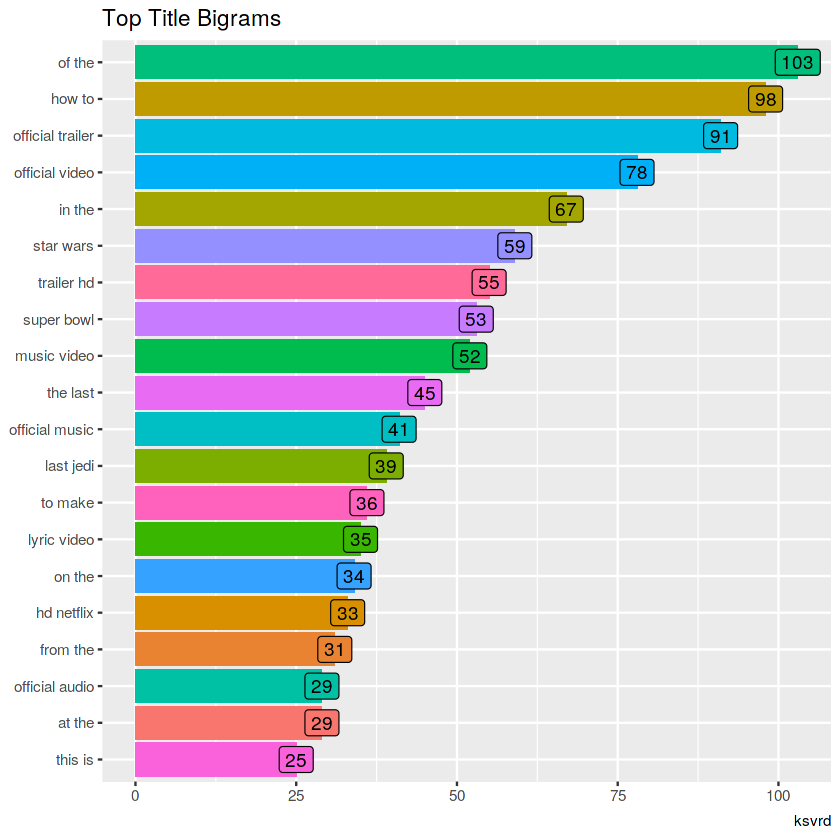

In [10]:
#Top Bigrams in Title
                    
bigram <- unnest_tokens(viral, bigram, title, token = "ngrams", n = 2)

bigram_df <- data.table(bigram)

top_bigram <- bigram_df %>% 
                  select(bigram) %>% 
                  group_by(bigram) %>% 
                  count() %>%
                  arrange(desc(n)) %>%
                  head(20)

top_bigram_bp <- ggplot(top_bigram,
                        aes(x = reorder(bigram, n),
                            y = n,
                            fill = bigram)) +
                    geom_bar(stat="identity")+
                    labs(caption="ksvrd",
                         title="Top Title Bigrams")+
                    guides(fill="none")+
                    xlab(NULL)+
                    ylab(NULL)+
                    geom_label(aes(label = n))+
                    coord_flip()
top_bigram_bp

Examples of Bigram "How to" and top Trigrams with "how to".

In [11]:
#Examples of Top Bigrams
i <- grep(x = viral$title, pattern = "How to")
of_the <- viral[i,] %>% select(title)
of_the %>% head()

#Top Trigrams in of_the
trigram_of_the <- unnest_tokens(of_the, trigram, title, token = "ngrams", n = 3)

top_trigram <- trigram_of_the %>% 
                  group_by(trigram) %>% 
                  count() %>%
                  arrange(desc(n)) %>%
                  head(20)
top_trigram %>% head(7)

title                                                            
1 How to be an Aquarius                                            
2 How to Make Mini Nutella Pies! | Cupcake Jemma                   
3 üéÉ How to make Pumpkin Pie Mistakes                               
4 How to do a beauty Vlog for Tarte Cosmetics                      
5 How to turn your car crash into a catchy song                    
6 How to make a Wooden Katana from hardwood flooring // Woodworking

trigram           n 
1 how to make       15
2 how to be          5
3 how to get         5
4 to be a            4
5 cupcake jemma how  2
6 how to do          2
7 how to take        2

Most Common Title Length

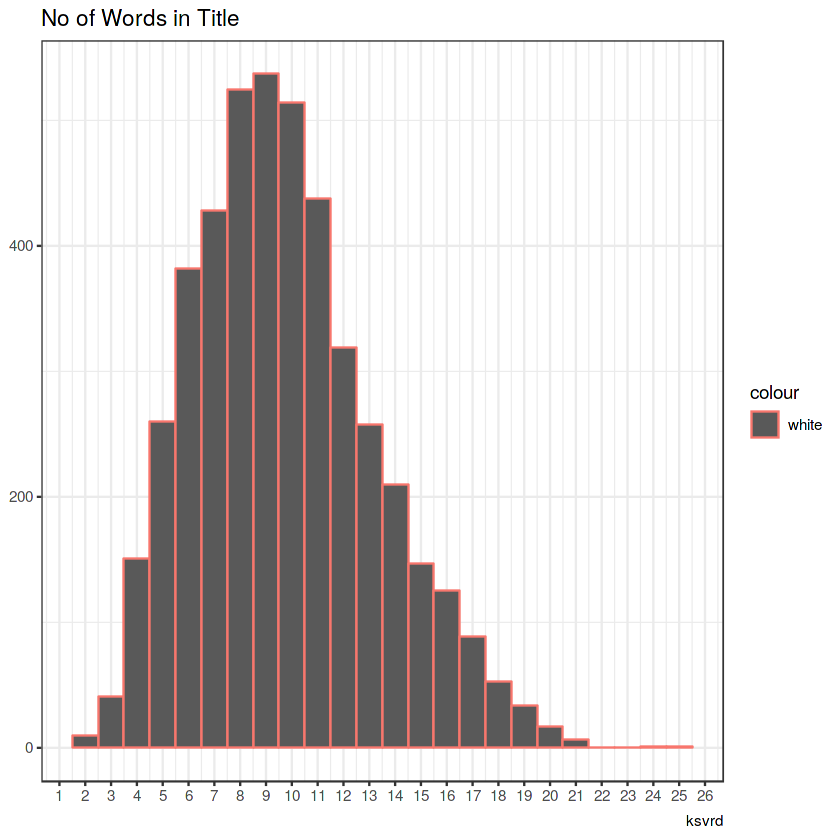

In [12]:
#Counting words in title
word_count <- function(string){
                sapply(strsplit(viral$title, " "), length) + 1
}

titleco <- word_count(viral$title)
titleco <- tbl_df(titleco)

ggplot(titleco, aes(value, col = "white"))+
  geom_histogram(binwidth = 1)+
  guides(fill="none")+
  labs(caption="ksvrd",
       title="No of Words in Title")+
  scale_x_continuous(breaks=seq(0, 26, 1))+
  xlab(NULL)+
  ylab(NULL)+
  theme_bw()

In [13]:
i <- grep(x = viral$title, pattern = "\\?")
question <- viral[i,] %>% select(title)
len <- length(i)

question %>% head()
len
244/length(viral$title)

title                                               
1 Nickelback Lyrics: Real or Fake?                    
2 I Dare You: GOING BALD!?                            
3 Which Countries Are About To Collapse?              
4 How does your body know you're full? - Hilary Coller
5 How Can You Control Your Dreams?                    
6 Is It Dangerous To Talk To A Camera While Driving?

[1] 244

[1] 0.05366176

## Tags

#### Key Questions
- What is the relationship between No. of tags and No. of views
- How many tags do viral videos have?
- What is the most common tag?

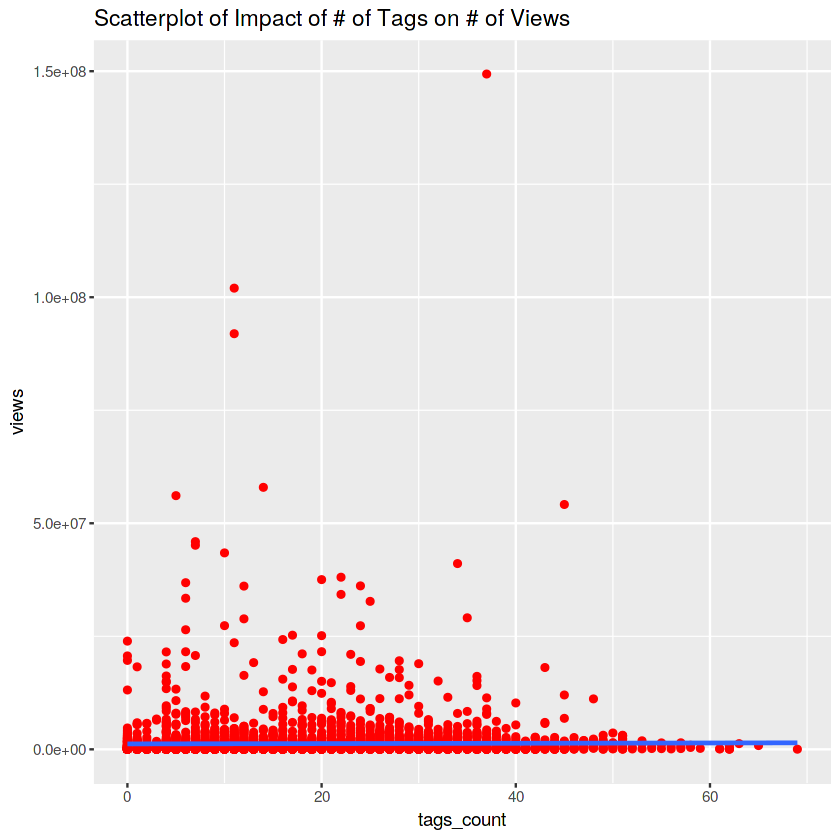

In [14]:
ggplot(viral, aes(tags_count, views)) + 
    geom_point(color='red') +
    geom_smooth(method = "lm", se = FALSE) +
    scale_x_continuous()+
    ggtitle("Scatterplot of Impact of # of Tags on # of Views")

In [15]:
viral %>% count(tags_count) %>% arrange(desc(n)) %>% head(7)

tags_count n  
1  0         208
2  7         160
3  8         153
4 10         152
5 11         144
6 30         143
7  4         141

Most Common Tags

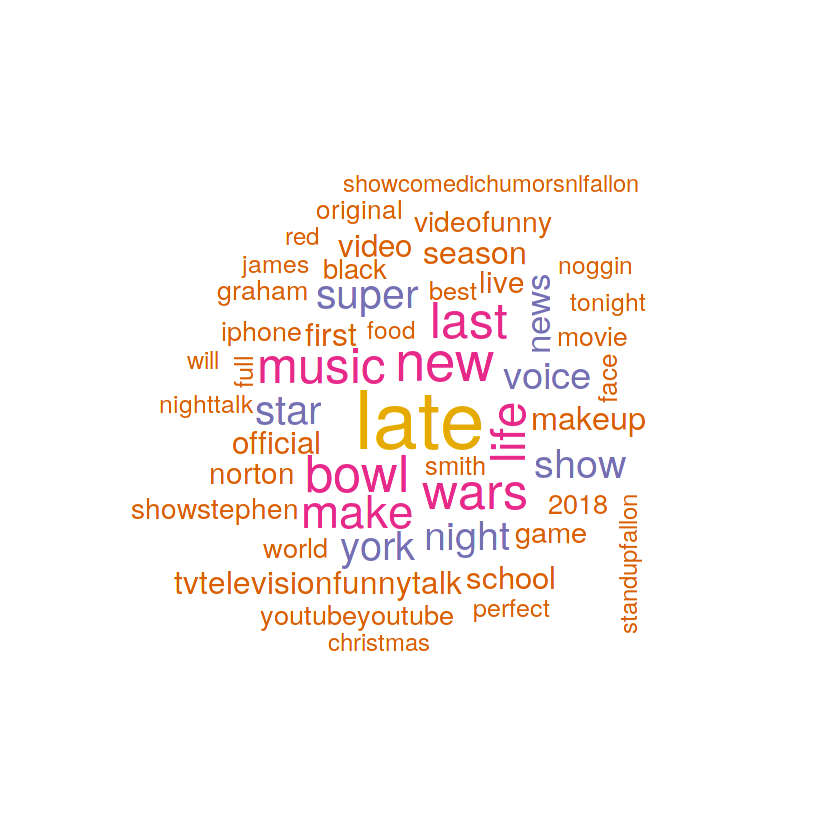

In [16]:
tags <- as.character(viral$tags) #create a vector of tags

tags4_source <- VectorSource(tags)
tags4_corpus <- VCorpus(tags4_source)

tags4_clean <- clean_corpus(tags4_corpus)
tags4_tdm <- TermDocumentMatrix(tags4_clean)# Create a TDM from desc_clean
tags4_m <- as.matrix(tags4_tdm) # Convert desc_tdm to a matrix

# Calculate the rowSums: term_frequency
term4_frequency <- rowSums(tags4_m)

# Sort term_frequency in descending order
term4_frequency <- sort(term4_frequency, decreasing = TRUE)

words <- names(term4_frequency)

# Word Cloud
wordcloud(words, term4_frequency, max.words = 50, colors = brewer.pal(6,"Dark2"), random.order = F)

## Key Take Aways
- No correlation between the number of tags and the number of views
- The most common number of tags, in order, is 0, 7, 8, 10, 11, and 30
- Most common tags are late, new, last, bowl, wars, make, life, and music.

## Time

#### Key Questions
- What is the best time of the day to post?
- How long does a video take to become viral?

Most Common Hour of the Day to Publish

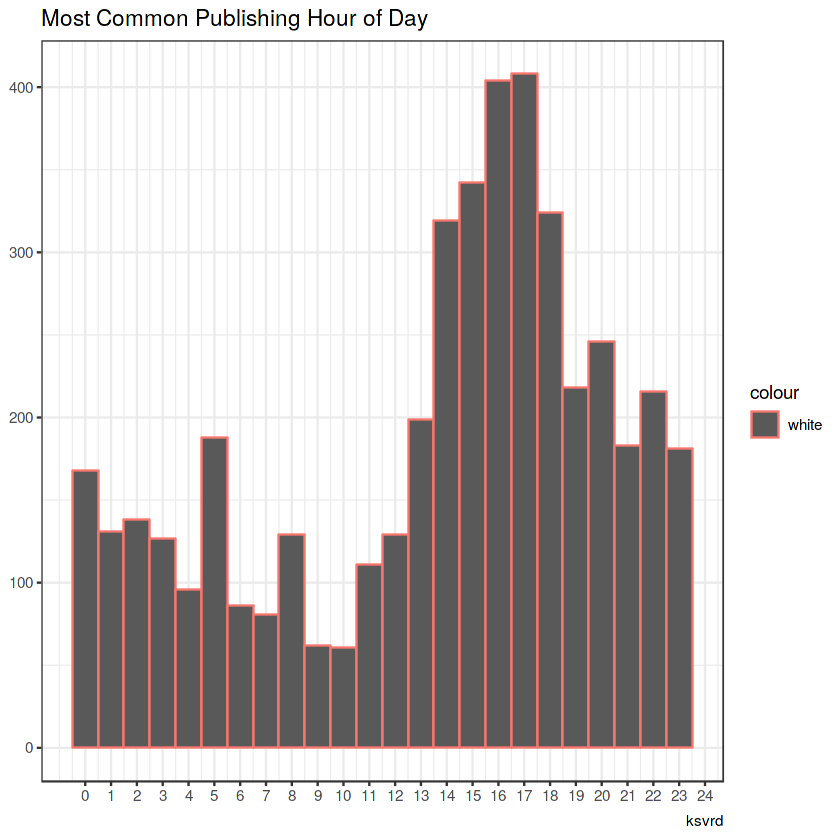

In [17]:
#Most Common Publish Hour
ggplot(viral, aes(publish_hour, col = "white"))+
  geom_histogram(binwidth = 1)+
  guides(fill="none")+
  labs(caption="ksvrd",
       title="Most Common Publishing Hour of Day")+
  scale_x_continuous(breaks=seq(0, 25, 1))+
  xlab(NULL)+
  ylab(NULL)+
  theme_bw()

Number of Days it typically takes to become trending

Warning message:
‚ÄúRemoved 97 rows containing missing values (geom_point).‚Äù

List of 59
 $ line                 :List of 6
  ..$ colour       : chr "black"
  ..$ size         : num 0.5
  ..$ linetype     : num 1
  ..$ lineend      : chr "butt"
  ..$ arrow        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_line" "element"
 $ rect                 :List of 5
  ..$ fill         : chr "white"
  ..$ colour       : chr "black"
  ..$ size         : num 0.5
  ..$ linetype     : num 1
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_rect" "element"
 $ text                 :List of 11
  ..$ family       : chr ""
  ..$ face         : chr "plain"
  ..$ colour       : chr "black"
  ..$ size         : num 11
  ..$ hjust        : num 0.5
  ..$ vjust        : num 0.5
  ..$ angle        : num 0
  ..$ lineheight   : num 0.9
  ..$ margin       :Classes 'margin', 'unit'  atomic [1:4] 0 0 0 0
  .. .. ..- attr(*, "valid.unit")= int 8
  .. .. ..- attr(*, "unit")= chr "pt"
  ..$ debug        : logi FALSE
  ..$ inherit.

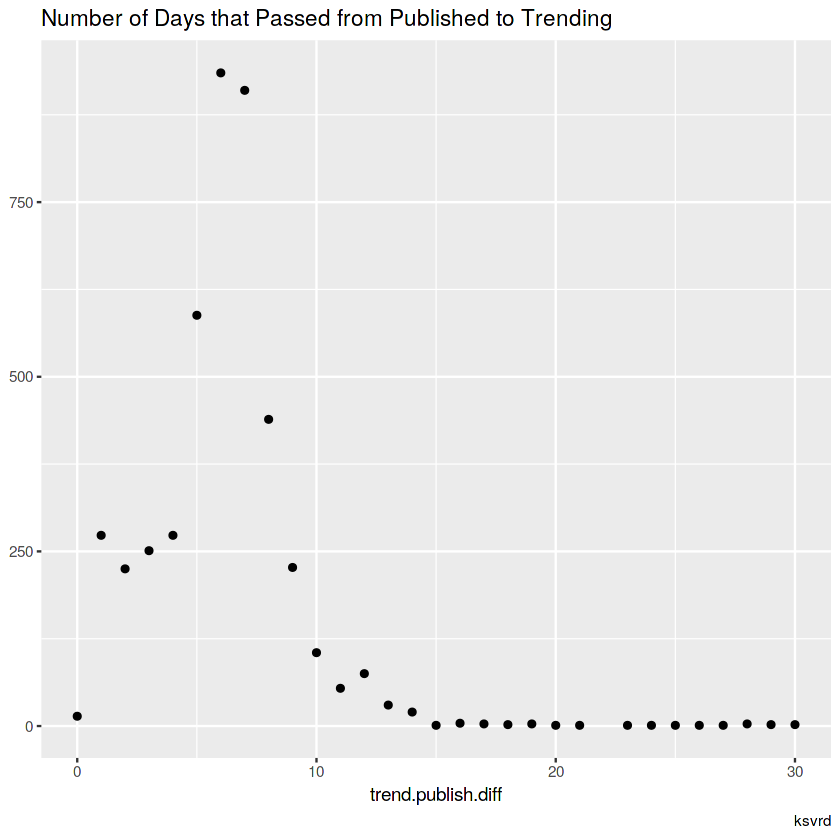

In [18]:
#Number of Days that Passed from Published to Trending
diff <- viral %>% select(trend.publish.diff) %>% group_by(trend.publish.diff) %>% count()

ggplot(diff, aes(x=trend.publish.diff, y=n))+
  geom_point()+
  labs(caption="ksvrd",
       title="Number of Days that Passed from Published to Trending")+
  ylab(NULL)+
  xlim(c(0,30))
  theme_bw()

## Key Take Aways

- The most common time to publish is between 3pm and 5pm
- The most common number of days that pass between a video publishing and going on the trending page is 6 or 7 days.

# Hope You Enjoyed. Leave a comment below :)